In [ ]:
os.chdir("..")

In [28]:
import os
import time
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)
import seaborn as sns
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import kpss

In [16]:
import pandas as pd
start = 0
interval = 10
scores_df = pd.read_csv("./objects/scores_df.csv")
mean_scores = pd.DataFrame(columns =['score'])
max_scores = pd.DataFrame(columns =['max_score'])

while interval <= len(scores_df):
    mean_scores.loc[len(mean_scores)] = (scores_df.loc[start:interval].mean()['scores'])
    max_scores.loc[len(max_scores)] = (scores_df.loc[start:interval].max()['scores'])
    start = interval
    interval = interval + 10    

3150

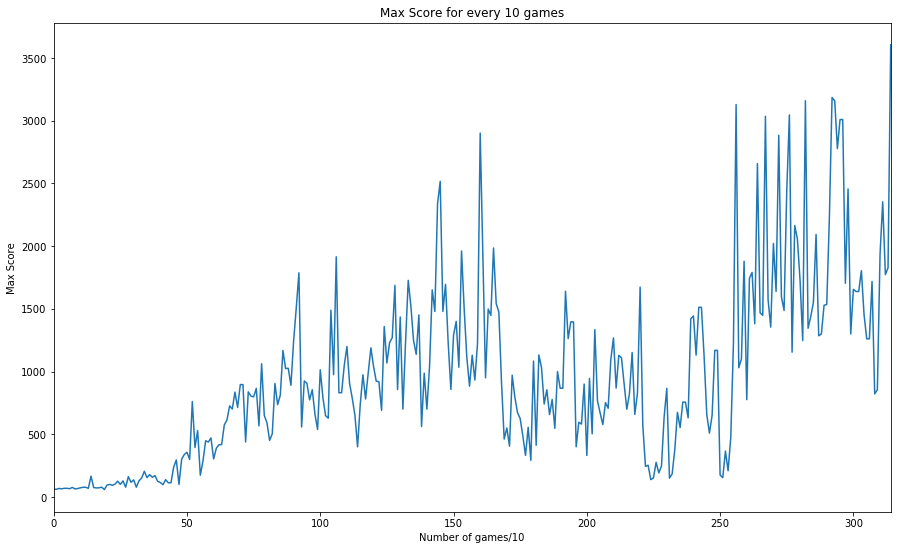

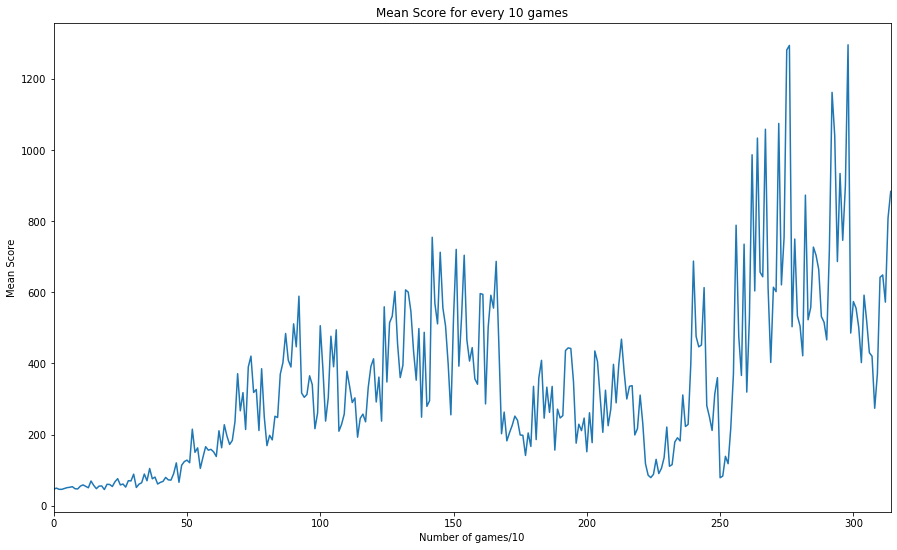

In [15]:

max_plot = max_scores.plot().legend_.remove()
plt.title("Max Score for every 10 games")
plt.xlabel("Number of games/10")
plt.ylabel("Max Score")
plt.savefig('plots/maxscoreplot.png')
plt.show(max_plot)


mean_plot = mean_scores.plot().legend_.remove()
plt.title("Mean Score for every 10 games")
plt.xlabel("Number of games/10")
plt.ylabel("Mean Score")
plt.savefig('plots/meanscoreplot.png')
plt.show(mean_plot)

In [37]:
from scipy.stats import norm


def mk_test(x, alpha=0.05):
    """
    This function is derived from code originally posted by Sat Kumar Tomer
    (satkumartomer@gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert
    1987) is to statistically assess if there is a monotonic upward or downward
    trend of the variable of interest over time. A monotonic upward (downward)
    trend means that the variable consistently increases (decreases) through
    time, but the trend may or may not be linear. The MK test can be used in
    place of a parametric linear regression analysis, which can be used to test
    if the slope of the estimated linear regression line is different from
    zero. The regression analysis requires that the residuals from the fitted
    regression line be normally distributed; an assumption not required by the
    MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best
    viewed as an exploratory analysis and is most appropriately used to
    identify stations where changes are significant or of large magnitude and
    to quantify these findings.
    Input:
        x:   a vector of data
        alpha: significance level (0.05 default)
    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics
    Examples
    --------
      >>> x = np.random.rand(100)
      >>> trend,h,p,z = mk_test(x,0.05)
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else:  # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(x == unique_x[i])
        var_s = (n*(n-1)*(2*n+5) - np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s > 0:
        z = (s - 1)/np.sqrt(var_s)
    elif s < 0:
        z = (s + 1)/np.sqrt(var_s)
    else: # s == 0:
        z = 0

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    if (z < 0) and h:
        trend = 'decreasing'
    elif (z > 0) and h:
        trend = 'increasing'
    else:
        trend = 'no trend'

    return trend, h, p, z


def check_num_samples(beta, delta, std_dev, alpha=0.05, n=4, num_iter=1000,
                      tol=1e-6, num_cycles=10000, m=5):
    """
    This function is an implementation of the "Calculation of Number of Samples
    Required to Detect a Trend" section written by Sat Kumar Tomer
    (satkumartomer@gmail.com) which can be found at:
    http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm
    As stated on the webpage in the URL above the method uses a Monte-Carlo
    simulation to determine the required number of points in time, n, to take a
    measurement in order to detect a linear trend for specified small
    probabilities that the MK test will make decision errors. If a non-linear
    trend is actually present, then the value of n computed by VSP is only an
    approximation to the correct n. If non-detects are expected in the
    resulting data, then the value of n computed by VSP is only an
    approximation to the correct n, and this approximation will tend to be less
    accurate as the number of non-detects increases.
    Input:
        beta: probability of falsely accepting the null hypothesis
        delta: change per sample period, i.e., the change that occurs between
               two adjacent sampling times
        std_dev: standard deviation of the sample points.
        alpha: significance level (0.05 default)
        n: initial number of sample points (4 default).
        num_iter: number of iterations of the Monte-Carlo simulation (1000
                  default).
        tol: tolerance level to decide if the predicted probability is close
             enough to the required statistical power value (1e-6 default).
        num_cycles: Total number of cycles of the simulation. This is to ensure
                    that the simulation does finish regardless of convergence
                    or not (10000 default).
        m: if the tolerance is too small then the simulation could continue to
           cycle through the same sample numbers over and over. This parameter
           determines how many cycles to look back. If the same number of
           samples was been determined m cycles ago then the simulation will
           stop.
        Examples
        --------
          >>> num_samples = check_num_samples(0.2, 1, 0.1)
    """
    # Initialize the parameters
    power = 1.0 - beta
    P_d = 0.0
    cycle_num = 0
    min_diff_P_d_and_power = abs(P_d - power)
    best_P_d = P_d
    max_n = n
    min_n = n
    max_n_cycle = 1
    min_n_cycle = 1
    # Print information for user
    print("Delta (gradient): {}".format(delta))
    print("Standard deviation: {}".format(std_dev))
    print("Statistical power: {}".format(power))

    # Compute an estimate of probability of detecting a trend if the estimate
    # Is not close enough to the specified statistical power value or if the
    # number of iterations exceeds the number of defined cycles.
    while abs(P_d - power) > tol and cycle_num < num_cycles:
        cycle_num += 1
        print("Cycle Number: {}".format(cycle_num))
        count_of_trend_detections = 0

        # Perform MK test for random sample.
        for i in xrange(num_iter):
            r = np.random.normal(loc=0.0, scale=std_dev, size=n)
            x = r + delta * np.arange(n)
            trend, h, p, z = mk_test(x, alpha)
            if h:
                count_of_trend_detections += 1
        P_d = float(count_of_trend_detections) / num_iter

        # Determine if P_d is close to the power value.
        if abs(P_d - power) < tol:
            print("P_d: {}".format(P_d))
            print("{} samples are required".format(n))
            return n

        # Determine if the calculated probability is closest to the statistical
        # power.
        if min_diff_P_d_and_power > abs(P_d - power):
            min_diff_P_d_and_power = abs(P_d - power)
            best_P_d = P_d

        # Update max or min n.
        if n > max_n and abs(best_P_d - P_d) < tol:
            max_n = n
            max_n_cycle = cycle_num
        elif n < min_n and abs(best_P_d - P_d) < tol:
            min_n = n
            min_n_cycle = cycle_num

        # In case the tolerance is too small we'll stop the cycling when the
        # number of cycles, n, is cycling between the same values.
        elif (abs(max_n - n) == 0 and
              cycle_num - max_n_cycle >= m or
              abs(min_n - n) == 0 and
              cycle_num - min_n_cycle >= m):
            print("Number of samples required has converged.")
            print("P_d: {}".format(P_d))
            print("Approximately {} samples are required".format(n))
            return n

        # Determine whether to increase or decrease the number of samples.
        if P_d < power:
            n += 1
            print("P_d: {}".format(P_d))
            print("Increasing n to {}".format(n))
            print("")
        else:
            n -= 1
            print("P_d: {}".format(P_d))
            print("Decreasing n to {}".format(n))
            print("")
            if n == 0:
                raise ValueError("Number of samples = 0. This should not happen.")

In [38]:
mk = mk_test(scores_df.scores)

In [39]:
mk

('increasing', True, 0.0, 23.996060380052967)